In [1]:
import ee
import geemap
ee.Authenticate()
ee.Initialize(project='ee-hyf7753')

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


In [2]:
# 定义云掩膜函数
def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.
      输入参数：image，一个Sentinel-2影像
      使用QA（Quality Assurance）波段来掩膜影像中的云和卷云

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')
  # 从影像中选择QA60波段
  # QA60 是一个位掩码带，其中包含栅格化的云掩码多边形，
  # 直到 2022-01-25 停止生成这些多边形。从 2024-02-28 开始，与传统一致的 QA60 带由 MSK_CLASSI 云分类带构建。

  # Bits 10 and 11 are clouds and cirrus, respectively.
  # 设置云和卷云的位掩码（cloud_bit_mask和cirrus_bit_mask），分别对应QA波段中的第10位和第11位
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  # 通过位运算和比较操作，生成一个掩膜，其中云和卷云区域被设置为False（即0），其他区域为True（即1）。
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)
# 应用这个掩膜到原始影像上，并除以10000（这通常是因为Sentinel-2的某些波段数据是以10000为单位的整数存储的，
# 除以10000可以将它们转换为浮点数以便进行进一步的分析或可视化）。

In [3]:
polygon = ee.Geometry.Polygon(
    [[[108.09458101775786, 34.30562265948671], [108.09501064847578, 34.30557687261404], [108.09493276022344, 34.30484602589277], [108.09450312950553, 34.304891812765455], [108.09458101775786, 34.30562265948671]]],
    None, False
)

dataset = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    # .filterDate('2023-01-01', '2023-05-30')
    .filterDate('2024-01-01', '2024-05-30')
    .filterBounds(polygon)  # 应用空间过滤器
    # Pre-filter to get less cloudy granules.
    # .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    # .map(mask_s2_clouds)
    .map(lambda img: img.set('date', ee.String(img.get('system:index')).slice(0, 8)))
    .sort('date')
)

timestamplist = (dataset.aggregate_array('date')
                 .map(lambda d: ee.String(d))
                 .getInfo())

timestamplist_uni = list(set(timestamplist))

In [10]:
timestamplist#不是排序了吗？？

['20240103',
 '20240103',
 '20240103',
 '20240108',
 '20240108',
 '20240108',
 '20240113',
 '20240113',
 '20240113',
 '20240118',
 '20240118',
 '20240118',
 '20240123',
 '20240123',
 '20240123',
 '20240128',
 '20240128',
 '20240128',
 '20240202',
 '20240202',
 '20240202',
 '20240207',
 '20240207',
 '20240207',
 '20240212',
 '20240212',
 '20240212',
 '20240217',
 '20240217',
 '20240217',
 '20240222',
 '20240222',
 '20240222',
 '20240227',
 '20240227',
 '20240227',
 '20240303',
 '20240303',
 '20240303',
 '20240308',
 '20240308',
 '20240308',
 '20240313',
 '20240313',
 '20240313',
 '20240318',
 '20240318',
 '20240318',
 '20240323',
 '20240323',
 '20240323',
 '20240328',
 '20240328',
 '20240328',
 '20240402',
 '20240402',
 '20240402',
 '20240407',
 '20240407',
 '20240407',
 '20240412',
 '20240412',
 '20240412',
 '20240417',
 '20240417',
 '20240417',
 '20240422',
 '20240422',
 '20240422',
 '20240427',
 '20240427',
 '20240427',
 '20240502',
 '20240502',
 '20240502',
 '20240507',
 '20240507',

In [5]:
dataset_filter_cloud = dataset.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

timestamplist_filter_cloud = (dataset_filter_cloud.aggregate_array('date')
                 .map(lambda d: ee.String(d))
                 .getInfo())

timestamplist_filter_cloud_uni = list(set(timestamplist_filter_cloud))

In [6]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
## 将时间轴拉到正常

t_periods_2023 = ['20230304',
                '20230327',
                '20230414',
                '20230425',
                '20230428',
                '20230502',
                '20230516']

t_periods_2024 = ['20240130',
                '20240417',
                '20240428',
                '20240506',
                '20240513',
                '20240520']

In [7]:
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题

df_timestamp0 = pd.DataFrame({'date0': timestamplist_uni, 'value0': 1})
# 将日期字符串转换为datetime对象（虽然对于散点图来说不是必需的，但可能有助于后续处理）
df_timestamp0['date0'] = pd.to_datetime(df_timestamp0['date0'], format='%Y%m%d')

df_timestamp1 = pd.DataFrame({'date1': timestamplist_filter_cloud_uni, 'value1': 2})
# 将日期字符串转换为datetime对象（虽然对于散点图来说不是必需的，但可能有助于后续处理）
df_timestamp1['date1'] = pd.to_datetime(df_timestamp1['date1'], format='%Y%m%d')

# df_timestamp2 = pd.DataFrame({'date2': t_periods_2023 ,'value2': 3})
df_timestamp2 = pd.DataFrame({'date2': t_periods_2024 ,'value2': 3})
# 将日期字符串转换为datetime对象（虽然对于散点图来说不是必需的，但可能有助于后续处理）
df_timestamp2['date2'] = pd.to_datetime(df_timestamp2['date2'], format='%Y%m%d')

l_df_timestamp = [df_timestamp0,df_timestamp1,df_timestamp2]

df_timestamp = pd.concat(l_df_timestamp,axis=1)

In [8]:
df_timestamp

,date0,value0,date1,value1,date2,value2
0,2024-01-18,1,2024-05-17,2.0,2024-01-30,3.0
1,2024-05-07,1,2024-04-17,2.0,2024-04-17,3.0
2,2024-02-12,1,2024-02-12,2.0,2024-04-28,3.0
3,2024-03-03,1,2024-01-28,2.0,2024-05-06,3.0
4,2024-01-08,1,2024-01-08,2.0,2024-05-13,3.0
5,2024-03-13,1,2024-03-18,2.0,2024-05-20,3.0
6,2024-02-17,1,2024-05-12,2.0,NaT,NaN
7,2024-05-17,1,2024-04-12,2.0,NaT,NaN
8,2024-04-27,1,2024-01-13,2.0,NaT,NaN
9,2024-04-17,1,2024-01-03,2.0,NaT,NaN


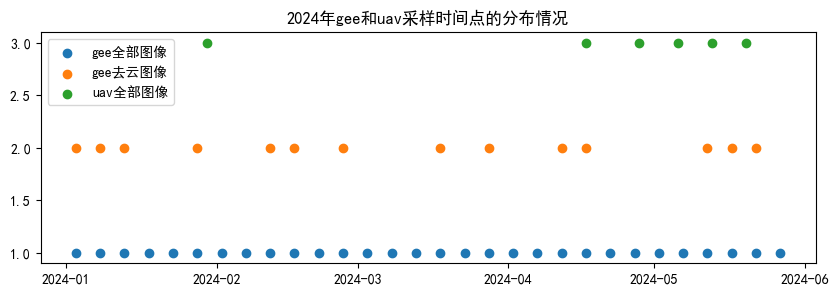

In [9]:
def draw_scatter_time_gee(df_timestamp,year):
    ## 将正常时间轴的数据可视化
    plt.figure(figsize=(10, 3))
    plt.scatter(df_timestamp['date0'],df_timestamp['value0'],label= 'gee全部图像')
    plt.scatter(df_timestamp['date1'],df_timestamp['value1'],label= 'gee去云图像')
    plt.scatter(df_timestamp['date2'],df_timestamp['value2'],label= 'uav全部图像')
    plt.legend()
    # plt.title('2023年标准时间轴某小区某band的变化')
    plt.title(f'{year}年gee和uav采样时间点的分布情况')
    plt.show()

year = 2024
draw_scatter_time_gee(df_timestamp,year)

In [ ]:
## 可视化
visualization = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}

# 选择一个图像进行可视化（例如，集合中的第一个图像）
image = dataset.first()

# 将Polygon添加到地图上（使用geemap的addLayer方法）
# 注意：由于geemap直接支持显示ee.Geometry对象，你不需要将其转换为其他格式
# 使用set_center()方法设置地图的中心点和缩放级别。
# 使用add_layer()方法将处理后的影像集合的平均值
m = geemap.Map()
# 定位和缩放到 Polygon 所在的区域
m.centerObject(polygon, zoom=17)  # 可以调整 zoom 级别以适合你的需求
m.add_layer(image, visualization, 'RGB')
m.addLayer(polygon, {'color': 'FF0000'}, 'Polygon Layer')
m

Map(center=[34.305234342790044, 108.09475688856978], controls=(WidgetControl(options=['position', 'transparent…